In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy as sp
import networkx as nx

from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from collections import defaultdict

%matplotlib inline
#%load_ext line_profiler

from matplotlib import rc
params = {'text.usetex': False, 'mathtext.fontset': 'stixsans', 'axes.linewidth': 2}
plt.rcParams.update(params)
plt.rcParams.update({'font.size': 10})
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 2

# simple grid world
functions to be defined:
* set initial and end position
* generate set of graphs with at least one path from inital to end pos
* take that set of graphs and generate graphs with rewards and punishments
    * rules for (R,P):
        * only one reward
        * maximum M punishments
        * at least one path without punishment

In [2]:
def plot_graph_matrix(G):
    plt.imshow(nx.to_numpy_matrix(G))
    
def init_state(G):
    return list(G.nodes)[np.random.randint(len(G.nodes))]

def draw_graph(G, fig_size):
    plt.figure(figsize=(fig_size[0], fig_size[1]))
    pos = {(x,y):(y,-x) for x,y in G.nodes()}
    nx.draw(G, pos=pos, 
            node_color='k', 
            with_labels=False,
            node_size=300)

In [3]:
def get_next_state(G, current_state, action):
    # given an initial state, outputs the next state after action is taken
    # need to insert rewards/punishments (probably should be a data structure)
    
    # get all edges of current_state node
    neigh_edges = G.edges(current_state)
    
    valid_state = False
    valid_transition = False
    
    if action == 0: #UP
        next_state = (current_state[0]-1, current_state[1])
    if action == 1: #DOWN
        next_state = (current_state[0]+1, current_state[1])    
    if action == 2: #LEFT
        next_state = (current_state[0], current_state[1]-1)    
    if action == 3: #RIGHT
        next_state = (current_state[0], current_state[1]+1)
        
    # check if next state is valid
    
    for node in G.nodes:
        if next_state == node:
            valid_state = True
    
    for edge in neigh_edges:
        if next_state == edge[1]:
            valid_transition = True
    
    if (valid_state & valid_transition):
        return next_state
    else:
        return current_state

# generate valid graphs
Rules:
* no isolated states - complete graph (formal definition)
* start and end state conditions
    * at least one path between start and end state
        * at least one path without punishments
        * this implies that we need to have at least 2 different paths for rewards

# generate a set of connected graphs with some edges removed

In [4]:
def remove_edges(G, n_edges):
    
    # generates a graph with n_edges removed

    for i in range(n_edges):
        n_total_edges = len(list(G.edges))
        random_edge = list(G.edges)[np.random.randint(n_total_edges)]
        G.remove_edge(random_edge[0],random_edge[1])
        
    return G

In [5]:
def generate_connected_graphs(grid_size, n_graphs, n_tries, n_edges_removed):
    
    c = 0
    g_list = []
    for n in range(n_tries):
        g = nx.grid_2d_graph(grid_size, grid_size)
        g = remove_edges(g, n_edges_removed)
        #print(nx.is_connected(g))
        if nx.is_connected(g):
            g_list.append(g)
            c +=1
        if c == n_graphs:
            break
            
    return g_list

In [6]:
grid_size = 5
n_graphs = 3
n_tries = 1000
n_edges = 15
f = nx.grid_2d_graph(grid_size,grid_size)
g_list = generate_connected_graphs(grid_size, n_graphs, n_tries, n_edges)
print(len(g_list))
print(len(list(f.edges)))
for e in g_list:
    print(len(list(e.edges)))

3
40
25
25
25


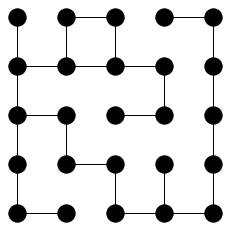

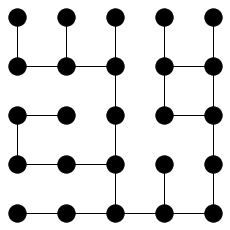

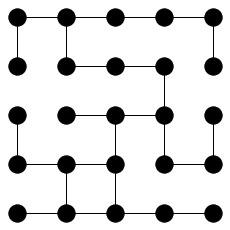

In [7]:
for e in g_list:
    plt.figure(figsize=(3,3))
    pos = {(x,y):(y,-x) for x,y in e.nodes()}
    nx.draw(e, pos=pos, 
            node_color='k', 
            with_labels=False,
            node_size=300)
    plt.show()

# pass graphs through node2vec

In [8]:
class node2vec():
    
    def __init__(self, graph, max_walks, walk_len):

        self.graph = graph
        
        probs = defaultdict(dict)
        for node in self.graph.nodes():
            probs[node]['probabilities'] = dict()
            
        self.probs = probs
        
        # these two parameters bias the exploration towards
        # depth or breadth
        
        self.p = 1 # return parameter - low value of p -> BFS
        self.q = 0.8 # runaway parameter - low value of q -> DFS
        
        self.max_walks = max_walks
        self.walk_len = walk_len
    
    def compute_probabilities(self):
        # calculate the biased transition probabilities for the 
        # random walks of the graph
        
        G = self.graph
        for source_node in G.nodes():
            for current_node in G.neighbors(source_node):
                probs_ = list()
                for destination in G.neighbors(current_node):
                    
                    # these probabilities will bias the random walks
                    if source_node == destination:
                        prob_ = G[current_node][destination].get('weight',1) * (1/self.p)
                    elif destination in G.neighbors(source_node):
                        prob_ = G[current_node][destination].get('weight',1)
                    else:
                        prob_ = G[current_node][destination].get('weight',1) * (1/self.q)

                    probs_.append(prob_)

                self.probs[source_node]['probabilities'][current_node] = probs_/np.sum(probs_)
    
    def generate_random_walks(self):
        # purpose here is to define sequences of paths along the graph
        # these sequences will later on be embedded in word2vec
        
        G = self.graph
        
        walks = list()
        for start_node in G.nodes():
            for i in range(self.max_walks):
                
                walk = [start_node]
                walk_options = list(G[start_node])
                
                if len(walk_options)==0:
                    break
                    
                first_step_idx = np.random.choice(len(walk_options))
                first_step = walk_options[first_step_idx]
                walk.append(first_step)
                
                for k in range(self.walk_len-2):
                    walk_options = list(G[walk[-1]])
                    if len(walk_options)==0:
                        break
                    probabilities = self.probs[walk[-2]]['probabilities'][walk[-1]]
                    next_step_idx = np.random.choice(len(walk_options), p=probabilities)
                    next_step = walk_options[next_step_idx]
                    walk.append(next_step)
                
                walks.append(walk)
        np.random.shuffle(walks)
        walks = [list(map(str,walk)) for walk in walks]
        
        return walks
    
    def get_walks(self):
        
        self.compute_probabilities()
        return self.generate_random_walks()
        

In [9]:
n2v_g = node2vec(g_list[0], 3, 5)

In [10]:
n2v_g.compute_probabilities()

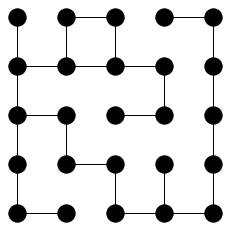

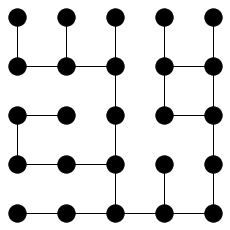

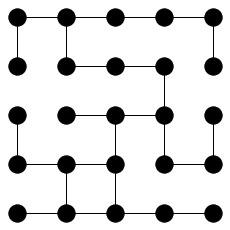

In [11]:
draw_graph(g_list[0],[3,3])
draw_graph(g_list[1],[3,3])
draw_graph(g_list[2],[3,3])

In [12]:
n2v_g.probs[(0,0)]

{'probabilities': {(1, 0): array([0.28571429, 0.35714286, 0.35714286])}}

In [13]:
walks = n2v_g.generate_random_walks()

In [14]:
walks

[['(0, 3)', '(0, 4)', '(0, 3)', '(0, 4)', '(1, 4)'],
 ['(3, 2)', '(4, 2)', '(3, 2)', '(4, 2)', '(4, 3)'],
 ['(4, 2)', '(4, 3)', '(4, 4)', '(3, 4)', '(4, 4)'],
 ['(3, 4)', '(2, 4)', '(3, 4)', '(4, 4)', '(3, 4)'],
 ['(0, 4)', '(1, 4)', '(2, 4)', '(3, 4)', '(4, 4)'],
 ['(2, 2)', '(2, 3)', '(1, 3)', '(1, 2)', '(1, 1)'],
 ['(1, 2)', '(1, 3)', '(2, 3)', '(1, 3)', '(2, 3)'],
 ['(3, 3)', '(4, 3)', '(4, 2)', '(3, 2)', '(3, 1)'],
 ['(3, 1)', '(3, 2)', '(4, 2)', '(4, 3)', '(3, 3)'],
 ['(3, 3)', '(4, 3)', '(4, 4)', '(4, 3)', '(4, 4)'],
 ['(4, 2)', '(3, 2)', '(3, 1)', '(3, 2)', '(3, 1)'],
 ['(2, 4)', '(3, 4)', '(4, 4)', '(3, 4)', '(2, 4)'],
 ['(1, 0)', '(2, 0)', '(1, 0)', '(0, 0)', '(1, 0)'],
 ['(1, 4)', '(2, 4)', '(1, 4)', '(0, 4)', '(0, 3)'],
 ['(4, 3)', '(3, 3)', '(4, 3)', '(4, 2)', '(3, 2)'],
 ['(2, 0)', '(2, 1)', '(3, 1)', '(3, 2)', '(4, 2)'],
 ['(3, 1)', '(3, 2)', '(4, 2)', '(3, 2)', '(4, 2)'],
 ['(4, 0)', '(3, 0)', '(4, 0)', '(3, 0)', '(2, 0)'],
 ['(4, 4)', '(3, 4)', '(2, 4)', '(1, 4)', '(0,

### now try to embed the sequences with word2vec
* plot one embedding per model
* check if the same maze run different times gives similar embeddings
* is there something better than t-sne to plot the embeddings

In [15]:
model = Word2Vec(walks, vector_size=128, window=5, min_count=0, sg=1, workers=1)

In [16]:
node_embeddings = model.wv.vectors

In [17]:
tsne = TSNE(n_components=2)
node_embeddings_2d = tsne.fit_transform(node_embeddings)

In [18]:
node_embeddings_2d.shape

(25, 2)

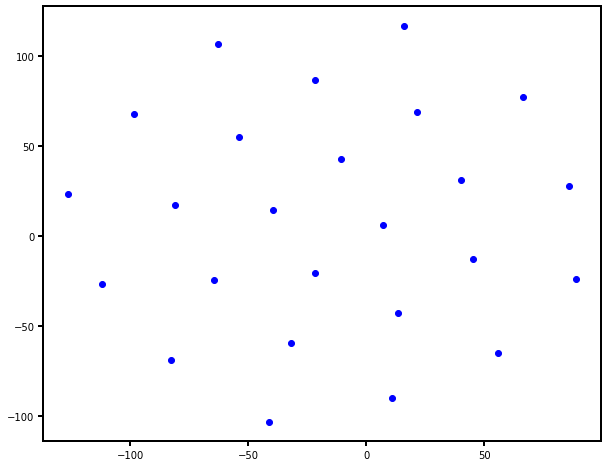

In [19]:
plt.figure(figsize=(10,8))
plt.scatter(node_embeddings_2d[:,0],
            node_embeddings_2d[:,1], c = 'Blue')
plt.show()

# embed a set of graphs

In [20]:
def paint_nodes(G, r_pos, p_pos, fig_size):
    plt.figure(figsize=(fig_size[0],fig_size[1]))
    
    nc = []
    for node in G.nodes:
        if node == r_pos:
            nc.append('g')
        if node == p_pos:
            nc.append('r')
        else:
            nc.append('k')
    
    del nc[-1]

    pos = {(x,y):(y,-x) for x,y in G.nodes()}
    nx.draw(G, pos = pos, 
            node_color = nc, 
            with_labels = False,
            node_size=300)

In [21]:
grid_size = 5
n_graphs = 2
n_tries = 100
n_edges = 15

f = nx.grid_2d_graph(grid_size, grid_size)
g1 = generate_connected_graphs(grid_size, 1, n_tries, 0)[0]
g2 = generate_connected_graphs(grid_size, 1, n_tries, 0)[0]

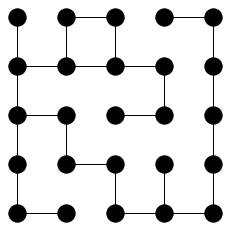

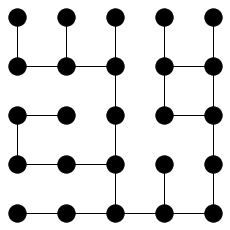

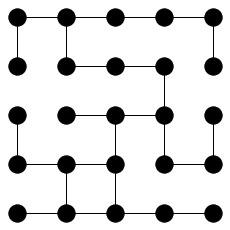

In [22]:
for g in g_list:
    draw_graph(g, [3,3])

# PCA
* testing

In [ ]:
pca = PCA(n_components=2)
pcs = pca.fit_transform(node_embeddings)

node_xy = []
for e in node_embeddings.T:
    node_xy.append([np.dot(e,pcs[:,1]),np.dot(e,pcs[:,0])])
    
for e in node_xy:
    plt.scatter(e[0],e[1])
plt.show()

# T-SNE
* write function to paint walks to check if they make sense
* calculate the successor features of the graph by doing random walks
    * there should be clustering and separation of the rooms

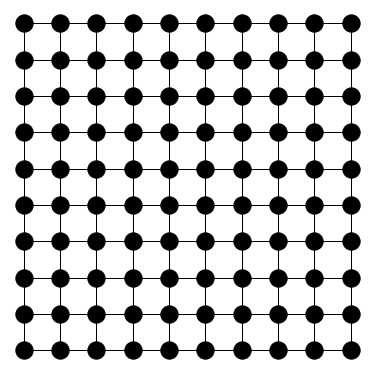

In [29]:
grid_size = 10
n_graphs = 2
n_tries = 100
n_edges = 15

f = nx.grid_2d_graph(grid_size, grid_size)
g1 = generate_connected_graphs(grid_size, 1, n_tries, 0)[0]

draw_graph(g1,[5,5])

In [30]:
def generate_4_room_maze():
    grid_size = 10
    n_graphs = 2
    n_tries = 100
    n_edges = 15

    f = nx.grid_2d_graph(grid_size, grid_size)
    g1 = generate_connected_graphs(grid_size, 1, n_tries, 0)[0]
    
    
    for i in range(grid_size):
        g1.remove_edge((4,i),(5,i))
        g1.remove_edge((i,4),(i,5))
        
    g1.add_edge((2,2),(5,2))
    g1.add_edge((2,4),(2,5))
    g1.add_edge((7,4),(7,5))
    g1.add_edge((4,7),(5,7))
    
    return g1

In [31]:
g4 = generate_4_room_maze()
draw_graph(g4,[5,5])

In [74]:
n2v_g = node2vec(g4, 20, 10)

In [75]:
g4_walks = n2v_g.get_walks()
w2v_m = Word2Vec(g4_walks, vector_size=50, window=10, min_count=1, sg=1, workers=1)
node_embeddings = w2v_m.wv.vectors
node_ids= w2v_m.wv.index_to_key

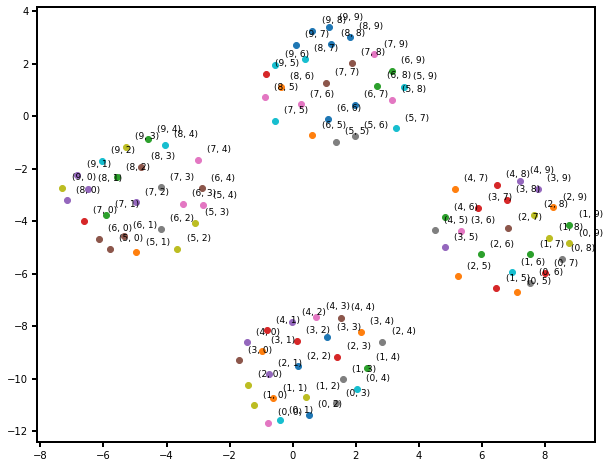

In [76]:
embs = tsne.fit_transform(node_embeddings)
plt.figure(figsize=(10,8))
for i,e in enumerate(node_ids):
    plt.scatter(embs[i,0], embs[i,1])
    plt.text(embs[i,0]+0.3, embs[i,1]+0.3, e, fontsize=9)
plt.show()

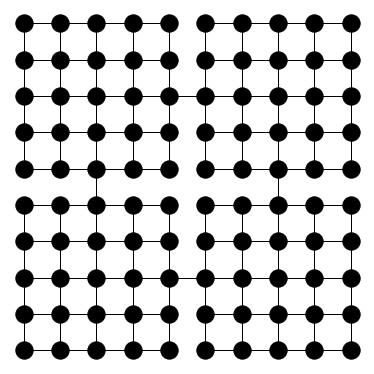

In [77]:
g4 = generate_4_room_maze()
draw_graph(g4,[5,5])

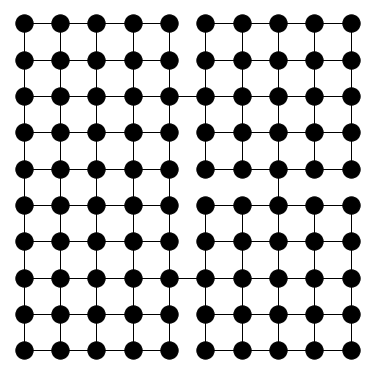

In [78]:
for i in range(5):
    g4.add_edge((4,i),(5,i))
draw_graph(g4, [5,5])

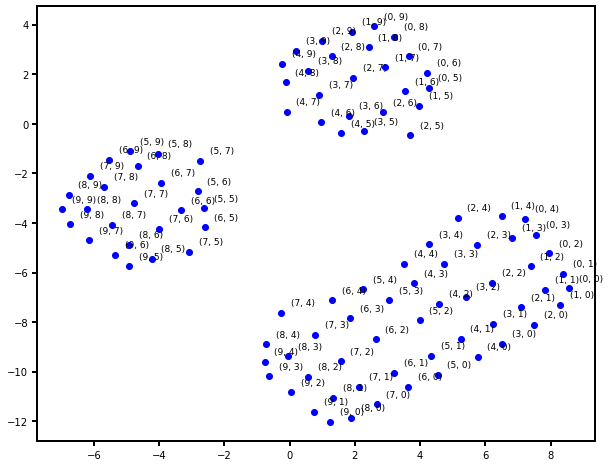

In [82]:
n2v_g = node2vec(g4, 20, 10)
g4_walks = n2v_g.get_walks()
w2v_m = Word2Vec(g4_walks, vector_size=50, window=10, min_count=1, sg=1, workers=1)
node_embeddings = w2v_m.wv.vectors
node_ids= w2v_m.wv.index_to_key

embs = tsne.fit_transform(node_embeddings)
plt.figure(figsize=(10,8))
for i,e in enumerate(node_ids):
    plt.scatter(embs[i,0], embs[i,1], color = 'b')
    plt.text(embs[i,0]+0.3, embs[i,1]+0.3, e, fontsize=9)
plt.show()